# SQL

This notebook reads in the .csv file data into a SQLite database.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('chained_assignment',None)

# Import listing data

In [2]:
fpath_listings_detailed = '../SanDiego/listings_detailed.csv'

list_df = pd.read_csv(fpath_listings_detailed)
print list_df.shape

(6608, 95)


# Explore Features

In [3]:
# 95 total features/columns

# 3 features
id_info = ['id', 'scrape_id', 'last_scraped']

# 11 features
basic_info = ['name','summary','space','description','experiences_offered',
              'neighborhood_overview','notes','transit','access',
              'interaction','house_rules']

# 14 features
location_info = ['street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed',
                 'city','state','zipcode','market','smart_location','country_code','country',
                 'latitude','longitude','is_location_exact']

# 9 features
property_info = ['property_type','room_type','accommodates','bathrooms','bedrooms',
                 'beds','bed_type','amenities','square_feet']

# 18 features
host_info = ['host_id','host_url','host_name','host_since','host_location','host_about',
             'host_response_time','host_response_rate','host_acceptance_rate',
             'host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood',
             'host_listings_count','host_total_listings_count','host_verifications',
             'host_has_profile_pic','host_identity_verified']

# 7 features
price_info = ['price','weekly_price','monthly_price','security_deposit',
              'cleaning_fee','guests_included','extra_people']

# 7 features
calendar_info = ['calendar_updated','has_availability','availability_30','availability_60',
                 'availability_90','availability_365','calendar_last_scraped']

# 11 features
review_info = ['number_of_reviews','first_review','last_review','review_scores_rating',
               'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
               'review_scores_communication','review_scores_location','review_scores_value',
               'reviews_per_month']
# 10 features
booking_info = ['minimum_nights','maximum_nights','requires_license','license',
                'jurisdiction_names','instant_bookable','cancellation_policy',
                'require_guest_profile_picture','require_guest_phone_verification',
                'calculated_host_listings_count']

# 5 features
url_info = ['listing_url','thumbnail_url','medium_url','picture_url','xl_picture_url']

total_info = id_info + basic_info + location_info + property_info + host_info + price_info + \
            calendar_info + review_info + booking_info + url_info
    
#print total_info
print len(total_info)
print [_ for _ in list(list_df.columns) if _ not in total_info]

95
[]


# Choose features for database

In [4]:
features = ['id','name','summary','space','description','experiences_offered','neighborhood_overview',
            'notes','transit','access','interaction','house_rules','street','neighbourhood',
            'neighbourhood_cleansed','neighbourhood_group_cleansed','city','state','zipcode','market',
            'smart_location','country_code','country','latitude','longitude','is_location_exact',
            'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
            'amenities','square_feet','host_id','host_since','host_response_time','host_response_rate',
            'host_acceptance_rate','host_listings_count','host_has_profile_pic','host_identity_verified',
            'price','weekly_price','monthly_price','security_deposit','cleaning_fee','guests_included',
            'extra_people','availability_365','number_of_reviews','first_review','last_review',
            'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
            'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month',
            'minimum_nights','instant_bookable','cancellation_policy','require_guest_phone_verification',
            'calculated_host_listings_count']

print 'Dropped features:'
print [_ for _ in list(list_df.columns) if _ not in features]
data_df = list_df[features]

Dropped features:
['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_location', 'host_about', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_total_listings_count', 'host_verifications', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture']


# Calculate occupancy

In [5]:
occupancy_features = ['id','name','availability_365','number_of_reviews','first_review','last_review',
                      'reviews_per_month','minimum_nights']

occupancy_df = data_df[occupancy_features]
occupancy_df['first_review'] =  pd.to_datetime(occupancy_df['first_review'])
occupancy_df['last_review'] =  pd.to_datetime(occupancy_df['last_review'])
occupancy_df['review_timespan'] = occupancy_df['last_review'] - occupancy_df['first_review']
print occupancy_df.shape
occupancy_df.head()

(6608, 9)


,id,name,availability_365,number_of_reviews,first_review,last_review,reviews_per_month,minimum_nights,review_timespan
0,11204286,Family friendly/California king,360,7,2016-05-23,2016-06-26,4.57,1,34 days
1,7972006,Welcome to Sunset Suite,80,7,2015-10-04,2016-06-07,0.76,2,247 days
2,7727710,San Diego/Eastlake. Gated community,0,1,2015-08-23,2015-08-23,0.09,1,0 days
3,13124681,Townhome in Eastlake,329,3,2016-06-13,2016-06-30,3.00,2,17 days
4,3469225,Bedroom suite in Large new home,335,0,NaT,NaT,NaN,1,NaT


In [80]:
# require at least 1 review
occupancy_df = occupancy_df[occupancy_df['number_of_reviews'] >= 1]
print occupancy_df.shape
occupancy_df.head()

(4590, 9)


,id,name,availability_365,number_of_reviews,first_review,last_review,reviews_per_month,minimum_nights,review_timespan
0,11204286,Family friendly/California king,360,7,2016-05-23,2016-06-26,4.57,1,34 days
1,7972006,Welcome to Sunset Suite,80,7,2015-10-04,2016-06-07,0.76,2,247 days
2,7727710,San Diego/Eastlake. Gated community,0,1,2015-08-23,2015-08-23,0.09,1,0 days
3,13124681,Townhome in Eastlake,329,3,2016-06-13,2016-06-30,3.00,2,17 days
5,877473,Private Bedroom in Newer Home,316,23,2013-07-17,2016-05-02,0.63,2,1020 days


# Plot Reviews

In [68]:
import seaborn as sns

TypeError: Cannot cast ufunc less input from dtype('float64') to dtype('<m8[ns]') with casting rule 'same_kind'

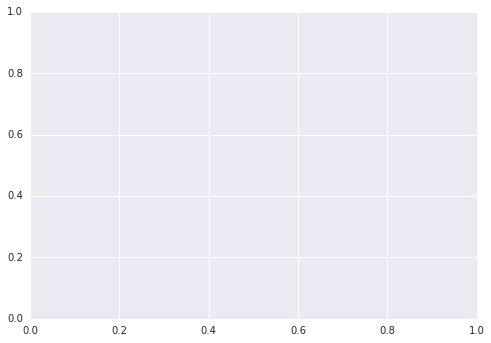

In [81]:
plt.hist(occupancy_df['review_timespan'])
plt.xlabel('timespan')
plt.show()

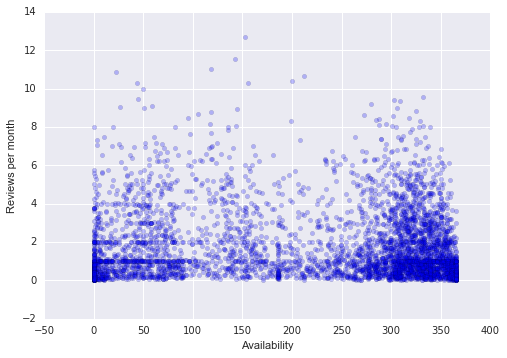

In [82]:
plt.scatter(occupancy_df['availability_365'],occupancy_df['reviews_per_month'], alpha=0.25)
plt.xlabel('Availability')
plt.ylabel('Reviews per month')
plt.show()